## 背景
1988年，加州通过了著名的99号提案：烟草税与健康保护法。其主要内容是对加州的卷烟销售征收每包25美分的州消费税，对其他商业类烟草产品（如雪茄和咀嚼型烟草）的销售也征收约同等的消费税。烟草销售的其他限制包括禁止在青少年可进入的公共区域安装自动售烟机，禁止个人销售香烟。同时，该法案产生的收入专门用于各种环境和保健计划以及反烟草广告。

为了评估该提案的对烟草销售的效果，研究者们收集多个州跨多年的香烟销售数据，具体而言，包含39个州从1970年到2000年的数据。(考虑到有些州采取了和和加州类似的烟草控制法案，为避免干扰，排除了这些州的数据)。

In [3]:
import pandas as pd
df = pd.read_csv(r'..\..\数据集\因果识别-合成控制法\DataSet\data\smoking.csv')
df.columns                

Index(['state', 'year', 'cigsale', 'lnincome', 'beer', 'age15to24', 'retprice',
       'california', 'after_treatment'],
      dtype='object')

In [4]:
#import data and drop unrelated columns
#cigsale:香烟销售, retprice:香烟价格
df = (
    pd.read_csv(r'DataSet\python-causality-handbook\causal-inference-for-the-brave-and-true\data\smoking.csv')
    .drop(columns=['lnincome', 'beer', 'age15to24'])
)
df.query('california').head()

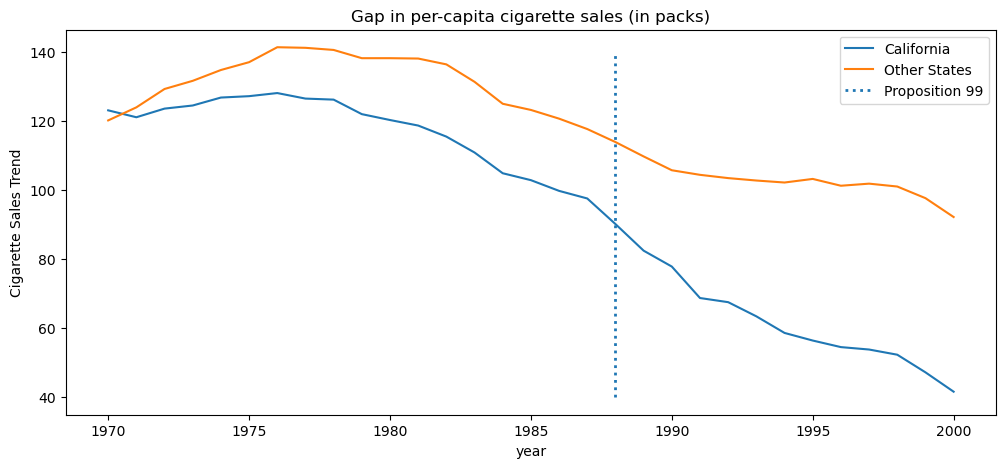

In [10]:
import matplotlib.pyplot as plt
import numpy as np
ax = plt.subplot(1,1,1)
(df
 .assign(california=(np.where(df['california'], 'California', 'Other States')))
 .groupby(['year','california'])['cigsale']
 .mean()
 .reset_index()
 #transform into pivot as sequentially data with state and cigsale
 .pivot('year', 'california', 'cigsale')
 .plot(ax=ax, figsize=(12,5))
)

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Cigarette Sales Trend")
plt.title("Gap in per-capita cigarette sales (in packs)")
plt.legend();  

上图显示，在该数据的时间轴范围内，加州居民的香烟消费量(cigsale)明显低于全国平均水平。 另外从80年代起，整体，香烟消费量是在下降的。 而在99号提案生效后，看上去加州的数据相比其他州有加速下降趋势，但我们不能过于肯定，毕竟这只是基于图示的猜测。
为了回答99号提案究竟对降低烟草消费有没有效果，我们基于开头介绍的合成控制的思想，通过干预前(pre-treatment period)的数据生成一个合成控制, 也就是说我们把其他州的数据通过线性加权组合起来，生成一个趋势和加州非常相像的假数据, 然后看看到这个合成控制对于干预后的预测结果。

## 建模
现在尝试用线性回归的方式来进行合成控制法中测试单元的权重估计。在合成控制法中，为了更好地对因果效应值(treatment effect)进行估计，我们尝试对捐赠池(donor poor)内的测试单元进行线性组合，合成一个虚拟的对照组(fake unit)，用来拟合试验中没有接受干预情况下的结果变量。那试验组测试单元与该合成控制下的结果变量间的差异，就是我们关心的策略/政策因果效应值(causal effect)。

具体而言，我们取干预(treatment)前的时序数据，我们基于最小二乘(ordinary least square)法，通过最小化试验组测试单元的结果变量与捐赠池内测试单元线性加权预测结果，两者间均方误差来拟合捐赠池中各个测试单元的权重。对于post-treatment期，我们用捐赠池里的测试单元的结果变量与学习到权重（$W=(w_i,...,w_{j+1})$）相乘，来预测我们在试验组的反事实结果 。

为了在python中实现线性回归，我们对数据的结构进行调整，我们把测试单元(unit)在这里对应是美国的州调整至列的位置，时间调整至行的位置。这里，我们有两个特征变量, cigsale和retprice, 我们用之前介绍过的方法将这两个特征进行整体(具体看如下代码)。

做完数据调整后，我们基于策略干预前的数据(1988年)用线性回归的方法拟合合成控制的权重向量，接着我们用干预后的数据来验证该合成控制的效果。(此处需要注意量纲)

In [14]:
features = ["cigsale", "retprice"]
inverted = (df.query("~after_treatment") # filter pre-treatment period
            .pivot(index='state', columns="year")[features] # make one column per year and one row per state
            .T) # flip the table to have one column per state

inverted.head()

state                 1           2           3           4           5   \
        year                                                               
cigsale 1970   89.800003  100.300003  123.000000  124.800003  120.000000   
        1971   95.400002  104.099998  121.000000  125.500000  117.599998   
        1972  101.099998  103.900002  123.500000  134.300003  110.800003   
        1973  102.900002  108.000000  124.400002  137.899994  109.300003   
        1974  108.199997  109.699997  126.699997  132.800003  112.400002   

state                 6           7           8           9           10  ...  \
        year                                                              ...   
cigsale 1970  155.000000  109.900002  102.400002  124.800003  134.600006  ...   
        1971  161.100006  115.699997  108.500000  125.599998  139.300003  ...   
        1972  156.300003  117.000000  126.099998  126.599998  149.199997  ...   
        1973  154.699997  119.800003  121.800003  124.400002  156.000000  ...   
        1974  151.300003  123.699997  125.599998  131.899994  159.600006  ...   

state                 30          31          32          33         34  \
        year                                                              
cigsale 1970  103.599998   92.699997   99.800003  106.400002  65.500000   
        1971  115.000000   96.699997  106.300003  108.900002  67.699997   
        1972  118.699997  103.000000  111.500000  108.599998  71.300003   
        1973  125.500000  103.500000  109.699997  110.400002  72.699997   
        1974  129.699997  108.400002  114.800003  114.699997  75.599998   

state                 35          36          37          38          39  
        year                                                              
cigsale 1970  122.599998  124.300003  114.500000  106.400002  132.199997  
        1971  124.400002  128.399994  111.500000  105.400002  131.699997  
        1972  138.000000  137.000000  117.500000  108.800003  140.000000  
        1973  146.800003  143.100006  116.599998  109.500000  141.199997  
        1974  151.800003  149.600006  119.900002  111.800003  145.800003  

[5 rows x 39 columns]

In [15]:
#线性回归中变量Y是加州(试验组)的结果变量;X是其他州共同的结果变量数据
y = inverted[3].values # state of california
X = inverted.drop(columns=3).values  # other states

In [16]:
#直接调用sklearn里的linear_model进行拟合。同时我们可以通过.ceof_命令得到各个测试单元(州)的权重结果。
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False).fit(X, y).coef_
weights_lr.round(3)

array([-0.436, -1.038,  0.679,  0.078,  0.339,  1.213,  0.143,  0.555,
       -0.295,  0.052, -0.529,  1.235, -0.549,  0.437, -0.023, -0.266,
       -0.25 , -0.667, -0.106, -0.145,  0.109,  0.242, -0.328,  0.594,
        0.243, -0.171, -0.02 ,  0.14 , -0.811,  0.362,  0.519, -0.304,
        0.805, -0.318, -1.246,  0.773, -0.055, -0.032])

In [17]:
#基于上述线性回归的权重结果构造出一个合成控制
calif_synth_lr = (df.query("~california")
                  .pivot(index='year', columns="state")["cigsale"]
                  .values
                  .dot(weights_lr))

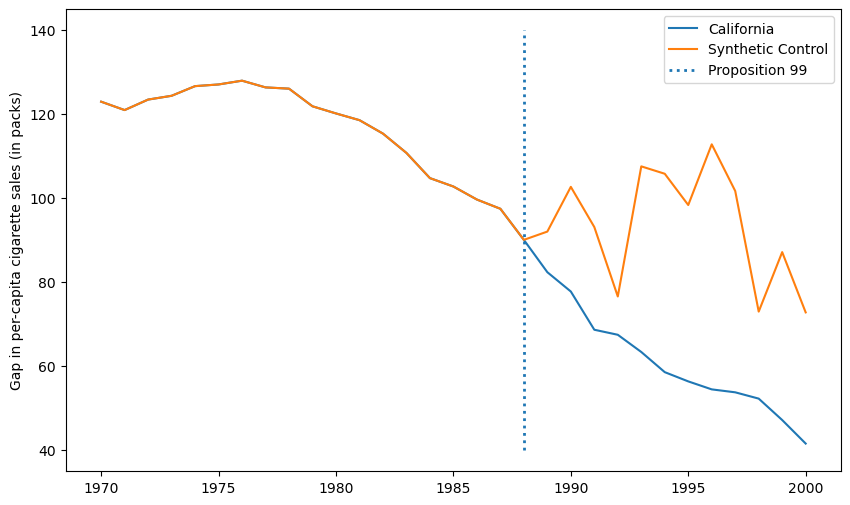

In [18]:
plt.figure(figsize=(10,6))
plt.plot(df.query("california")["year"], df.query("california")["cigsale"], label="California")
plt.plot(df.query("california")["year"], calif_synth_lr, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();

在上图中，蓝色的曲线是真实的加州香烟销量的结果，红色的曲线是基于线性回归合成控制的结果，垂直的虚线是政策生效的时间点。我们可以先该合成控制对于干预发生后的预测结果，我们第一印象是，在没有干预的情况下香烟的销量是高于政策生效后的销量，也就是该法案降低了香烟的销量。但同时我们可以看到基于在干预前(in-sample)的数据红色的线与蓝色的线完全重合了，说明线性回归对于干预前的数据拟合的很好；但在干预后(out-of-sample)的数据，上上下下波动很大，而非理想情况下平滑的模式。这意味我们基于线性回归生成的合成控制预测结果很大可能是过拟合了(overfitting)。

In [19]:
#可以尝试带正则项的回归模型(sparse linear models)如lasso或ridge进行拟合来改善上述的结果。但在这里，让我们先尝试经典的合成控制中参数拟合的实现方法。
from typing import List
from operator import add
from toolz import reduce, partial

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

#保证我们拟合的权重向量和为1
from scipy.optimize import fmin_slsqp

def get_w(X,y):
    w_start = [1/X.shape[1]]*X.shape[1]
    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                        np.array(w_start),
                         f_eqcons = lambda x: np.sum(x)-1,
                         bounds = [(0.0,1.0)]*len(w_start),
                         disp=False
                        )
    return weights

calif_weights = get_w(X, y)
print("Sum:", calif_weights.sum())
np.round(calif_weights, 4)

Sum: 1.000000000000091


array([0.    , 0.    , 0.    , 0.0852, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.113 , 0.1051, 0.4566, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.2401, 0.    , 0.    , 0.    , 0.    , 0.    ])

In [20]:
#根据上述生成的权重结果来生成新的合成控制
calif_synth = (df.query("~california")
               .pivot(index='year', columns="state")["cigsale"]
               .values
               .dot(calif_weights)
              )

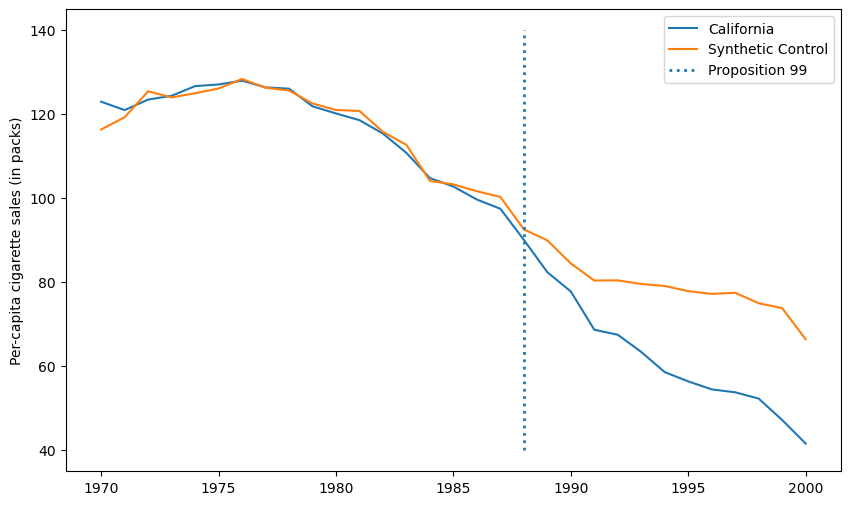

In [22]:
plt.figure(figsize=(10,6))
plt.plot(df.query("california")["year"], df.query("california")["cigsale"], label="California")
plt.plot(df.query("california")["year"], calif_synth, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Per-capita cigarette sales (in packs)")
plt.legend()

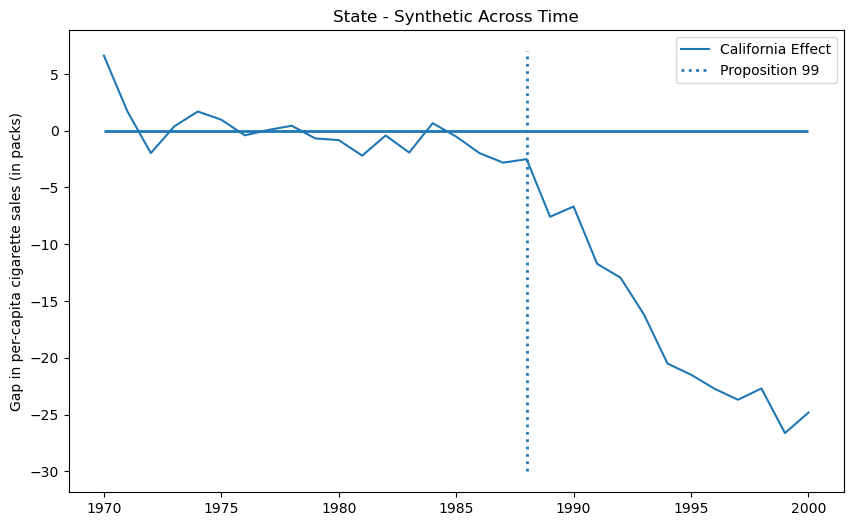

In [23]:
#只看GAP
plt.figure(figsize=(10,6))
plt.plot(df.query("california")["year"], df.query("california")["cigsale"] - calif_synth,
         label="California Effect")
plt.vlines(x=1988, ymin=-30, ymax=7, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=2)
plt.title("State - Synthetic Across Time")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();

## 显著性推断

在比较案例研究中，我们经常遇到的问题是我们的样本规模过小。如在这99号法案里我们总共有约小有39个点(N<40)，这种情况下，我们可以考虑Fisher’s Exact Test(对于N>=40的情况，我们可以考虑(chi-square)卡方检验)。我们检验的思想很简单，对所有的测试单元枚举着排列组合。在我们之前的例子里，我们的试验组是测试单元 
 , 在后续我们假定每个测试单元$j=1$ ,在后续我们假定每个测试单元$j=2,...,J$都有机会是试验组，而其余的是控制组。

对于每个州，我们重复使用之前的受约束的优化框架框架进行权重拟合，计算并生成一个对应合成控制(synthetic control)和相应的因果效应值。我们知道，在该数据集中，99号法案只对于加州生效。那我们把其他州当成试验组的情况，理论上我们做的是一个A/A测试或安慰剂试验(placebo test),相应地，理论上其因果效应值应该是很小的，甚至接近于0的。在给定生成的所有州的结果，我们可以用加州拟合出来的因果效应值与其他州的进行比较，如果加州的因果效应值远高于其他州的结果，那我们结果大概率是可信的。基于上述想法，我们可以写如下函数,该函数将一个州做为试验组输入然后进行合成控制法的计算。同时，该函数返回一个包含四列的dataFrame，列1是state_id,列2是year,列3是cigsale，列四是州的合成控制结果。

In [24]:
def synthetic_control(state: int, data: pd.DataFrame) -> np.array:
    
    features = ["cigsale", "retprice"]
    
    inverted = (data.query("~after_treatment")
                .pivot(index='state', columns="year")[features]
                .T)
    
    y = inverted[state].values # treated
    X = inverted.drop(columns=state).values # donor pool

    weights = get_w(X, y)
    #generate weight
    synthetic = (data.query(f"~(state=={state})")
                 .pivot(index='year', columns="state")["cigsale"]
                 .values
                 .dot(weights))

    return (data.query(f"state=={state}")[["state", "year", "cigsale", "after_treatment"]].assign(synthetic=synthetic))


from joblib import Parallel, delayed

control_pool = df["state"].unique()

parallel_fn = delayed(partial(synthetic_control, data=df))
#generate a list of dataframe of state synthetic result
synthetic_states = Parallel(n_jobs=8)(parallel_fn(state) for state in control_pool)
synthetic_states[0].head()

,state,year,cigsale,after_treatment,synthetic
0,1,1970,89.800003,False,95.029419
1,1,1971,95.400002,False,99.118199
2,1,1972,101.099998,False,101.881329
3,1,1973,102.900002,False,103.938655
4,1,1974,108.199997,False,107.038474


现在就可以比较比较合成控制预测的结果变量和真实的结果变量之间的差异。用田野试验的术语(field experiments), 对于加州，我们做的是A/B试验， 我们比较的结果是因果效应值。而对于其他州，我们做的试验则是，安慰剂试验(placebo testing)或A/A试验，我们比较的结果是安慰剂效应(placebo effect)。我们可以把加州策略的效应值和其他州的placebo effect用可视化的方式呈现:

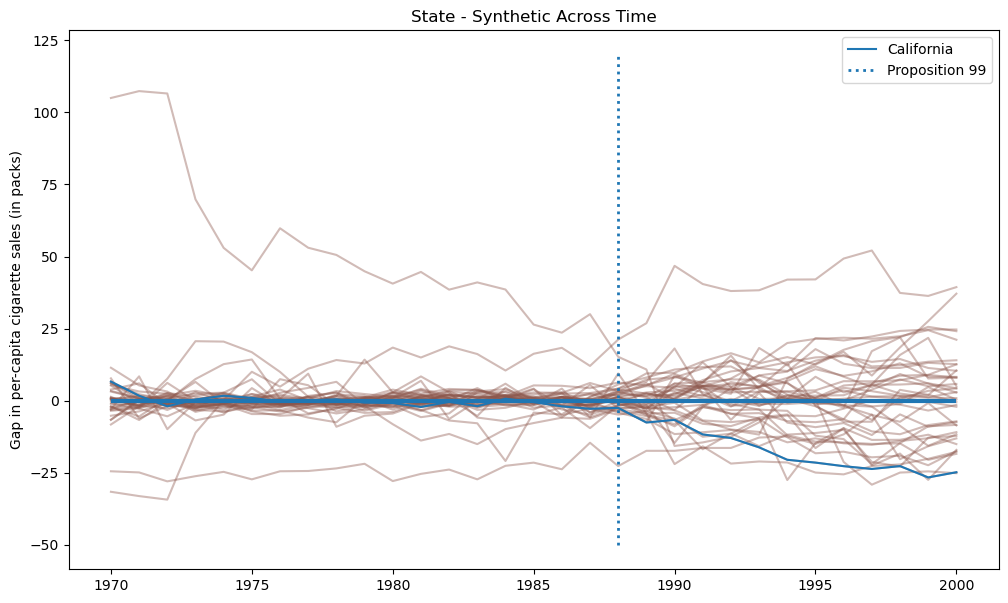

In [26]:
plt.figure(figsize=(12,7))
for state in synthetic_states:
    plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(df.query("california")["year"], df.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("State - Synthetic Across Time")
plt.legend();

- 1)我们可以看到在干预后的方差(variance)要远高于干预前的方差, 这和我们预期中的是一致的，我们新方法的优化目标是最小化干预前的数据点的均方误差。
- 2)我们同时也可以观察到对于有些州(测试单元)我们的模型即使是在干预前的数据，拟合的不是很好。这和我们预期中的也是一致的，如对于一个销量最高或最低的州，我们基于内插值interpolation思想的模型是不可能拟合的很好的。

对于拟合结果不太好的州，我们可以认为其是噪声从数据集中去除。一个简单的方法是我们对于干预前(pre-intervention)设置一个误差的阈值(threshold), 对于误差大于阈值的州我们将其从数据中删除。

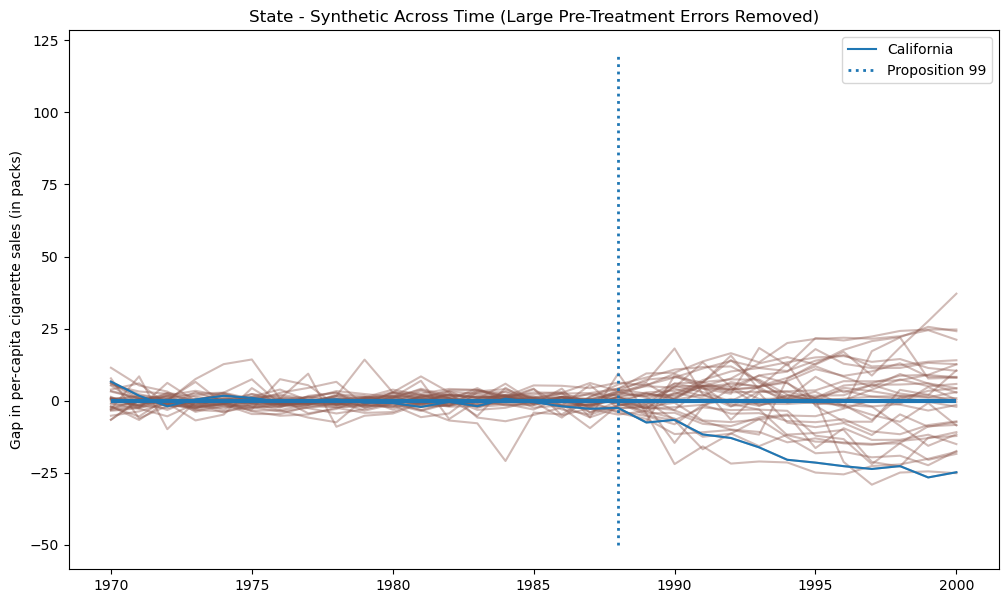

In [27]:
def pre_treatment_error(state):
    pre_treat_error = (state.query("~after_treatment")["cigsale"] 
                       - state.query("~after_treatment")["synthetic"]) ** 2
    return pre_treat_error.mean()

plt.figure(figsize=(12,7))
for state in synthetic_states:
    
    # remove units with mean error above 80.
    if pre_treatment_error(state) < 80:
        plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(df.query("california")["year"], df.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("Distribution of Effects")
plt.title("State - Synthetic Across Time (Large Pre-Treatment Errors Removed)")
plt.legend();

通过去除数据中的noise,我们可以从上图中看到和其他州的效应值相比，加州在干预后有明显的降低的效果。但我们更希望有更严格的基于假设检验的结论。

In [29]:
calif_number = 3
effects = [state.query("year==2000").iloc[0]["cigsale"] - state.query("year==2000").iloc[0]["synthetic"]
           for state in synthetic_states
           if pre_treatment_error(state) < 80] # filter out noise
calif_effect = df.query("california & year==2000").iloc[0]["cigsale"] - calif_synth[-1] 
print("California Treatment Effect for the Year 2000:", calif_effect)
np.array(effects)

California Treatment Effect for the Year 2000: -24.830159766665894


array([  5.79715881,   0.89458991, -24.83015977,  -7.16628126,
       -10.92204867,  37.11640559, -15.06971718,  -0.49805145,
       -18.45795089,  21.13366428,  12.57782752,  -1.47547825,
        10.49627378, -11.67012347,   4.29850819,   8.04811396,
        14.02322406,   8.25002748,   0.32576356,  -8.40826894,
        -2.12402715,  -7.42865075,   2.96157527,  24.10478147,
         4.25211767, -17.75844561,   7.93334015,   2.81640139,
        12.64955968, -17.47677511, -25.16040942, -12.26469124,
        24.69067401,  10.36299574,  -8.59880324])

我们可以尝试做一个单边测试(one-sided hypothesis)来验证我们结论:99号法案对香烟销量的影响是负的。 我们的原假设$H_0$ 
 可以是99号法案对香烟销量的影响是非负的；我们的备择假设$H_1$(alternative hypothesis) 
 可以为:9号法案对香烟销量的影响是负的(<0)。我们可以基于Fisher exact test来计算P-value: 具体而言，我们可以计算在上述计算出的效应值中，将加州作为试验组计算出的效应值高于其他州的比例。

对于上式，以2000年为例，我们计算出来的加州的效应值是-24.8，在其余34个 placebo effects中，我们只观察到一个州的效应值高于加州。因此，我们有 PV=1/35。

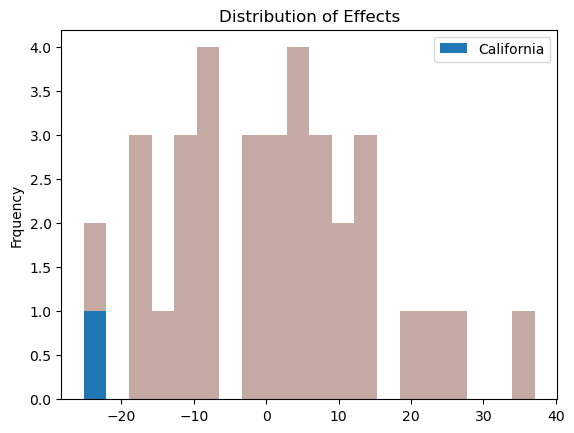

In [31]:
#将所有州结果的效应值用直方图的图示表示，然后显示加州的结果在图中的位置
_, bins, _ = plt.hist(effects, bins=20, color="C5", alpha=0.5);
plt.hist([calif_effect], bins=bins, color="C0", label="California")
plt.ylabel("Frquency")
plt.title("Distribution of Effects")
plt.legend();

## 总结
在政策/策略评估中场景中，如果我们只有如城市/省/州等实体的聚合数据(aggregated data), 这时候DID(difference-in-difference)方法并不能很好地做归因。在DID中，我们需要寻找一个和试验组相似，可以表征试验组反事实情况(假设试验组没有接受到干预)的对照组，但这样理想的对照组，在现实中我们很难找到。

作为DID的升级版，合成控制法给了我们一个更好的解决方案。我们可以学习和构成基于若干个和试验组相近的测试单元线性组成的合成控制来表征一个虚拟的试验组。基于该合成控制，我们模拟出试验组没有接受到干预的结果并计算因果效应值。

最后，我们展示了如何基于Fisher的精确试验(Fisher’s Exact Tests)来测试该合成控制结果统计上的显著性。具体而言，我们对所有没有接到干预的测试单元都尝试生成一个成合成控制，然后计算其安慰剂效应值(placebo effect)或A/A效应值，再和我们试验组的效应值进行比较。通过这样的方式，我们来评估我们学习到的策略的因果效应值是否显著。